In [2]:
import random
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

from scipy.stats import norm, skewnorm, gamma

In [3]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [4]:
import koopman_probabilistic
import model_objs

In [5]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

In [6]:
def MAE(x, x_hat):
    assert len(x) == len(x_hat)
    return np.sum(np.abs(x - x_hat)) / len(x)

In [7]:
def gaussian_quantiles(mu, sigma, quantiles):
    T = len(mu)
    assert(len(mu) == len(sigma))
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = norm(mu[t], sigma[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [8]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    assert(len(rate) == len(a))
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [9]:
def pinball_loss(data, quant_preds, quantiles):
    assert(len(data) == len(quant_preds))
    loss = 0
    for t in range(len(data)):
        for i in range(len(quantiles)):
            q = quantiles[i]
            quant_pred = quant_preds[t][i]
            if quant_pred > data[t]:
                loss += (quant_pred - data[t]) * (1 - q)
            else:
                loss += (data[t] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

# Gamma with time varying parameters

In [15]:
horizon = 400
horizons = [10, 50, 100, 400, 1_000, 10_000, 100_000]
train_through = 4000
t_vec = np.arange(train_through + horizons[-1])

periods = [96, 12]
a_vec = (np.exp(np.sin(2 * np.pi * t_vec / periods[0])) + np.cos(2 * np.pi * t_vec / periods[1])) ** 2 + 4
scale_vec = 0.5 * np.sin(2 * np.pi * t_vec / periods[1]) + np.cos(2 * np.pi * t_vec / periods[0]) + 2
x2 = np.random.gamma(a_vec, scale=scale_vec).reshape(-1, 1)

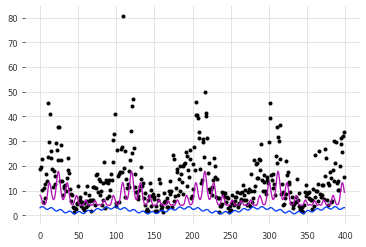

In [11]:
idx = 400
plt.plot(x2[:idx], ".")
plt.plot(scale_vec[:idx])
plt.plot(a_vec[:idx])

## Darts forecast

In [12]:
from darts.utils.likelihood_models import GammaLikelihood, GaussianLikelihood

In [13]:
df = pd.DataFrame({"t_vec": pd.to_datetime(t_vec, unit="D"), "x_vec": x2[:, 0]})

from darts import TimeSeries

# Create a TimeSeries, specifying the time and value columns
series2 = TimeSeries.from_dataframe(df, 't_vec', 'x_vec')[:train_through]

In [62]:
NBEATSModel?

Init signature: NBEATSModel(*args, **kwargs)
Docstring:     
The base class for "global" forecasting models, handling several time series and optional covariates.

Global forecasting models expand upon the functionality of `ForecastingModel` in 4 ways:
1. Models can be fitted on many series (multivariate or univariate) with different indices.
2. The input series used by `predict()` can be different from the series used to fit the model.
3. Covariates can be supported (multivariate or univariate).
4. They can allow for multivariate target series and covariates.

The name "global" stems from the fact that a training set of a forecasting model of this class is not constrained
to a temporally contiguous, "local", time series.

All implementations have to implement the `fit()` and `predict()` methods defined below.
The `fit()` method is meant to train the model on one or several training time series, along with optional
covariates.

If `fit()` has been called with only one training and cova

[2021-12-30 19:13:52,936] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3413 samples.
[2021-12-30 19:13:52,936] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3413 samples.
[2021-12-30 19:13:53,118] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-30 19:13:53,118] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


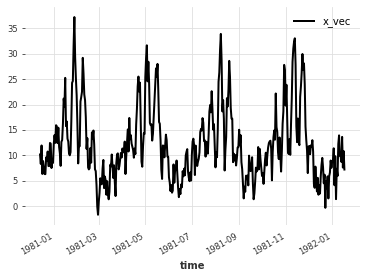

In [105]:
from darts.models import NBEATSModel

nbmodel2 = NBEATSModel(input_chunk_length=188, output_chunk_length=horizon)
nbmodel2.fit(series2)
prednb2 = nbmodel2.predict(horizon)

prednb2.plot()

[2021-12-29 18:05:21,200] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2021-12-29 18:05:21,200] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2021-12-29 18:05:21,207] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-29 18:05:21,207] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


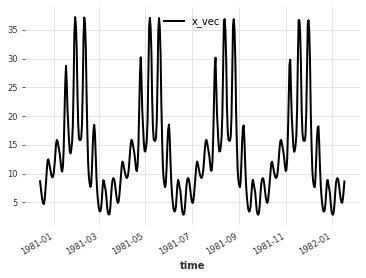

In [18]:
from darts.models import RNNModel

modlstm2 = RNNModel(model="LSTM", input_chunk_length=188, n_rnn_layers=1, dropout=0, hidden_dim=25, training_length=200)
modlstm2.fit(series2)
predlstm2 = modlstm2.predict(horizon)

predlstm2.plot()

[2021-12-29 18:35:17,621] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2021-12-29 18:35:17,621] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2021-12-29 18:35:17,628] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-29 18:35:17,628] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


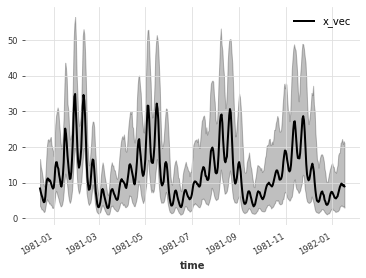

In [19]:
from darts.models import RNNModel  # probabilistic

modlstm2gamma = RNNModel(model="LSTM", input_chunk_length=188, n_rnn_layers=1, dropout=0, hidden_dim=25, training_length=200, likelihood=GammaLikelihood())
modlstm2gamma.fit(series2)
predlstm2gamma = modlstm2gamma.predict(horizon, num_samples=1000)

predlstm2gamma.plot()

[2021-12-29 18:56:00,083] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3717 samples.
[2021-12-29 18:56:00,083] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3717 samples.
[2021-12-29 18:56:00,088] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2021-12-29 18:56:00,088] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2021-12-29 18:56:00,093] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-29 18:56:00,093] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


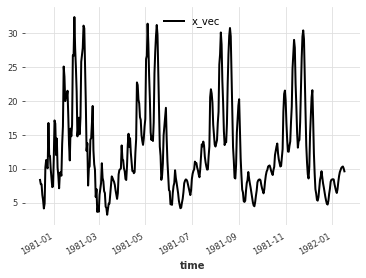

In [20]:
from darts.models import TCNModel

modeltcn2 = TCNModel(input_chunk_length=188, output_chunk_length=96)
modeltcn2.fit(series2)
predtcn2 = modeltcn2.predict(horizon)

predtcn2.plot()

In [21]:
#probabilistic
from darts.models import TCNModel

modeltcn2gamma = TCNModel(input_chunk_length=188, output_chunk_length=96, dropout=0, kernel_size=3, num_filters=3, likelihood=GammaLikelihood())
modeltcn2gamma.fit(series2)
predtcn2gamma = modeltcn2gamma.predict(horizon, num_samples=1000)

predtcn2gamma.plot()

[2021-12-29 19:01:47,424] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3717 samples.
[2021-12-29 19:01:47,424] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3717 samples.
[2021-12-29 19:01:47,428] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2021-12-29 19:01:47,428] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2021-12-29 19:01:47,429] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-29 19:01:47,429] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


In [22]:
num_freqs = [2, 2]
num_fourier = 2
model2 = model_objs.GammaNLL(x_dim=x2.shape[1], num_freqs=num_freqs, n=256)
k2 = koopman_probabilistic.KoopmanProb(model2, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)
k2.find_fourier_omegas(x2[:train_through], hard_code=periods)

fourier periods: tensor([96.0000, 12.0000], dtype=torch.float64)


tensor([0.0654, 0.5236], dtype=torch.float64)

In [23]:
k2.fit(x2[:train_through], iterations=8000, verbose=True, interval=20, cutoff=0, weight_decay=1e-7, lr_theta=1e-4, lr_omega=0, training_mask=None);

Iteration  0
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  14.772526
Iteration  1
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  10.219506
Iteration  2
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  8.172268
Iteration  3
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  6.99122
Iteration  4
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  6.2153277
Iteration  5
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  5.660914
Iteration  6
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.], grad_fn=<MulBackward0>)
Loss:  5.241425
Iteration  7
tensor([96., 12., 96., 12.])
Setting periods to tensor([96., 12., 96., 12.]

In [24]:
predict_through = train_through + horizon
params2 = k2.predict(predict_through)
rate_hat, a_hat = params2
scale_hat = 1 / rate_hat
path = "./darts_comparisons/synthGamma1"
np.save(path + "_rate.py", rate_hat)
np.save(path + "_a.py", a_hat)

In [25]:
mean_hat2 = model2.mean(params2)
std_hat2 = model2.std(params2)

In [26]:
%matplotlib inline
plt.subplots(figsize=(5, 7), dpi=120)
idx = 150 + train_through
plt.subplot(211)
pt = np.arange(predict_through)
plt.plot(pt[train_through:], x2[train_through:predict_through], ".", markersize=1.5, label="data")
# colors = [(i / len(quantiles), 0, 0) for i in range(len(quantiles))]
# for j in range(0, len(quantiles), 1):
#     plt.plot(pt[idx:], quant_preds[idx:, j], color=colors[j], linewidth=0.5, label=quantiles[j])
plt.plot(pt[idx:], mean_hat2[idx:], label="$\hat \mu$")
plt.plot(pt[idx:], mean_hat2[idx:] + std_hat2[idx:], "--k", linewidth=0.5, label="$\hat \mu \pm \hat \sigma$")
plt.plot(pt[idx:], mean_hat2[idx:] - std_hat2[idx:], "--k", linewidth=0.5)
plt.axvline(idx, color="k", linewidth=0.4)
plt.legend(loc="upper right", framealpha=1)
plt.subplot(212)
plt.plot(scale_vec[train_through:predict_through], "b", label="$\\beta$")
plt.plot(scale_hat[train_through:], "--k", label="$\hat \\beta$")
plt.plot(a_vec[train_through:predict_through], "orange", label="$\\alpha$")
plt.plot(a_hat[train_through:], ":k", label="$\hat \\alpha$")
plt.legend(loc="upper right", framealpha=1)

In [27]:
%matplotlib inline
plt.subplots(figsize=(5, 7), dpi=120)
idx = 150
plt.subplot(211)
pt = np.arange(predict_through)
plt.plot(x2[:predict_through], ".", markersize=1.5, label="data")
# colors = [(i / len(quantiles), 0, 0) for i in range(len(quantiles))]
# for j in range(0, len(quantiles), 1):
#     plt.plot(pt[idx:], quant_preds[idx:, j], color=colors[j], linewidth=0.5, label=quantiles[j])
plt.plot(pt[idx:], mean_hat[idx:], label="$\hat \mu$")
plt.plot(pt[idx:], mean_hat[idx:] + std_hat[idx:], "--k", linewidth=0.5, label="$\hat \mu \pm \hat \sigma$")
plt.plot(pt[idx:], mean_hat[idx:] - std_hat[idx:], "--k", linewidth=0.5)
plt.axvline(idx, color="k", linewidth=0.4)
plt.legend(loc="upper right", framealpha=1)
plt.subplot(212)
plt.plot(scale_vec[:predict_through], "b", label="$\\beta$")
plt.plot(scale_hat, "--k", label="$\hat \\beta$")
plt.plot(a_vec[:predict_through], "orange", label="$\\alpha$")
plt.plot(a_hat, ":k", label="$\hat \\alpha$")
plt.legend(loc="upper right", framealpha=1)

NameError: name 'mean_hat' is not defined

In [189]:
print("DPK:", MAE(x2[train_through:], mean_hat2[train_through:]))
print("NBEATS:", MAE(x2[train_through:], prednb2.values()))
print("LSTM:", MAE(x2[train_through:], predlstm2.values()))
print("TCN:", MAE(x2[train_through:], predtcn2.values()))

DPK: 3.90809655895432
NBEATS: 4.556679901132158
LSTM: 7.115793488783282
TCN: 4.250938898993342


In [106]:
print("DPK:", MAE(x2[train_through:train_through + horizon], mean_hat2[train_through:]))
print("NBEATS:", MAE(x2[train_through:train_through + horizon], prednb2.values()))
print("LSTM:", MAE(x2[train_through:train_through + horizon], predlstm2.values()))
print("TCN:", MAE(x2[train_through:train_through + horizon], predtcn2.values()))

DPK: 4.217806505077792
NBEATS: 4.785072821021539
LSTM: 7.666139722838012
TCN: 4.543524030957088


In [30]:
num_quants = 9
quantiles = np.arange(1, num_quants + 1, dtype=np.float32) / (num_quants + 1)
predlstm2quantiles = predlstm2gamma.quantiles_df(quantiles)
predtcn2quantiles = predtcn2gamma.quantiles_df(quantiles)

In [31]:
predlstm2quantiles = np.array([[float(predlstm2quantiles.values[i, j].values) for j in range(num_quants)] for i in range(horizon)])
predtcn2quantiles = np.array([[float(predtcn2quantiles.values[i, j].values) for j in range(num_quants)] for i in range(horizon)])

In [32]:
# path = "./darts_comparisons/synthGamma1"
# rate_hat = np.load(path + "_rate.py.npy")
# a_hat = np.load(path + "_a.py.npy")

In [33]:
quant_preds2 = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

In [73]:
print("DPK:", pinball_loss(x2[train_through:], quant_preds2[train_through:], quantiles))
print("LSTM:", pinball_loss(x2[train_through:], predlstm2quantiles, quantiles))
print("TCN:", pinball_loss(x2[train_through:], predtcn2quantiles, quantiles))

DPK: [1.50673981]
LSTM: [1.73073369]
TCN: [1.65715706]


In [35]:
print("DPK:", pinball_loss(x2[train_through:train_through + horizon], quant_preds2[train_through:], quantiles))
print("LSTM:", pinball_loss(x2[train_through:train_through + horizon], predlstm2quantiles, quantiles))
print("TCN:", pinball_loss(x2[train_through:train_through + horizon], predtcn2quantiles, quantiles))

DPK: [1.61733846]
LSTM: [1.73654062]
TCN: [1.6973333]


In [41]:
pinballs2 = {"DPK": [], "LSTM": [], "TCN": []}
MAEs2 = {"DPK": [], "LSTM": [], "TCN": [], "NBEATS": []}

for h in horizons:
    
    print(h)
    print("# dpk")
    predict_through = train_through + h
    _params2 = k2.predict(predict_through)
    _rate_hat, _a_hat = _params2
    _scale_hat = 1 / _rate_hat
    path = "./darts_comparisons/synthGamma1_" + str(h)
    np.save(path + "_rate.py", _rate_hat)
    np.save(path + "_a.py", _a_hat)
    _mean_hat2 = model2.mean(_params2)
    _std_hat2 = model2.std(_params2)
    _quant_preds2 = gamma_quantiles(_rate_hat, _a_hat, quantiles=quantiles)
    pinballs2["DPK"].append(pinball_loss(x2[train_through:train_through + h], _quant_preds2[train_through:], quantiles))
    MAEs2["DPK"].append(MAE(x2[train_through:train_through + h], _mean_hat2[train_through:]))

    print("# lstm gamma")
    _predlstm2gamma = modlstm2gamma.predict(h, num_samples=1000)
    _predlstm2quantiles = _predlstm2gamma.quantiles_df(quantiles)
    _predlstm2quantiles = np.array([[float(_predlstm2quantiles.values[i, j].values) for j in range(num_quants)] for i in range(h)])
    pinballs2["LSTM"].append(pinball_loss(x2[train_through:train_through + h], _predlstm2quantiles, quantiles))

    # lstm
    _predlstm2 = modlstm2.predict(h)
    MAEs2["LSTM"].append(MAE(x2[train_through:train_through + h], _predlstm2.values()))

    print("# tcn gamma")
    _predtcn2gamma = modeltcn2gamma.predict(h, num_samples=1000)
    _predtcn2quantiles = _predtcn2gamma.quantiles_df(quantiles)
    _predtcn2quantiles = np.array([[float(_predtcn2quantiles.values[i, j].values) for j in range(num_quants)] for i in range(h)])
    pinballs2["TCN"].append(pinball_loss(x2[train_through:train_through + h], _predtcn2quantiles, quantiles))

    # tcn
    _predtcn2 = modeltcn2.predict(h)
    MAEs2["TCN"].append(MAE(x2[train_through:train_through + h], _predtcn2.values()))

    # nbeats WARNING this is not how N-BEATs is meant to be used since it must be trained for a specific forecast horizon
    _prednb2 = nbmodel2.predict(h)
    MAEs2["NBEATS"].append(MAE(x2[train_through:train_through + h], _prednb2.values()))
    

10
# dpk
# lstm gamma
# tcn gamma
50
# dpk
# lstm gamma
# tcn gamma
100
# dpk
# lstm gamma
# tcn gamma
400
# dpk
# lstm gamma
# tcn gamma
1000
# dpk
# lstm gamma
# tcn gamma
10000
# dpk
# lstm gamma
# tcn gamma


ValueError: Expected parameter concentration (Tensor of shape (32, 188, 1)) of distribution Gamma(concentration: torch.Size([32, 188, 1]), rate: torch.Size([32, 188, 1])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[[3.1870],
         [3.3786],
         [3.2789],
         ...,
         [4.4022],
         [4.6163],
         [4.1414]],

        [[4.2153],
         [4.4088],
         [3.9615],
         ...,
         [4.5906],
         [5.1666],
         [4.8430]],

        [[3.2730],
         [2.5150],
         [3.2474],
         ...,
         [4.6713],
         [5.0811],
         [4.3041]],

        ...,

        [[3.0978],
         [3.5882],
         [2.8690],
         ...,
         [4.5185],
         [4.7802],
         [4.8173]],

        [[2.5918],
         [3.4474],
         [4.1100],
         ...,
         [4.9786],
         [4.3793],
         [4.9965]],

        [[3.1796],
         [3.1724],
         [2.9594],
         ...,
         [5.4494],
         [5.3860],
         [5.2771]]], dtype=torch.float64)

In [130]:
pinballs2

{'DPK': [array([1.98260973]),
  array([2.3640627]),
  array([1.64943678]),
  array([1.61733846]),
  array([1.58606717]),
  array([1.54229711]),
  array([1.54634008])],
 'LSTM': [array([2.26161396]),
  array([2.45647085]),
  array([1.78243794]),
  array([1.72415087]),
  array([1.82547888]),
  array([2.7001954]),
  nan],
 'TCN': [array([2.06923517]),
  array([2.47499666]),
  array([1.82264529]),
  array([1.69809751]),
  array([1.67739559]),
  nan,
  nan]}

In [51]:
MAEs2

{'DPK': [4.667402632058051,
  6.113525512857953,
  4.281855826885147,
  4.217806505077792,
  4.137197961511464,
  4.011321355113477],
 'LSTM': [5.4467821689907705,
  6.363844063373608,
  5.589720424983031,
  7.666139722838012,
  7.828868040594049,
  10.073217301903926],
 'TCN': [5.078617803873299,
  6.560022015639041,
  4.771606452457814,
  4.543524030957088,
  4.686816979987156],
 'NBEATS': [4.673002383883107,
  6.177399710757872,
  4.901716732821513,
  4.451777601008783,
  4.3981001040572485]}

# Gaussian with time-varying mean and variance

In [52]:
t_vec = np.arange(4000 + horizons[-1])
mu_vec = 2 * np.sin(1 + np.sin(2 * np.pi * t_vec / 48))
sigma_vec = np.exp(np.sin(2 * np.pi * t_vec / 31) - 1) + 0.5
x = np.random.normal(mu_vec, sigma_vec).reshape(-1, 1)

## Darts forecast

In [53]:
df = pd.DataFrame({"t_vec": pd.to_datetime(t_vec, unit="D"), "x_vec": x[:, 0]})

from darts import TimeSeries

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, 't_vec', 'x_vec')[:train_through]

In [63]:
from darts.models import RNNModel

mod = RNNModel(model="LSTM", input_chunk_length=96, n_rnn_layers=1, dropout=0, hidden_dim=25, training_length=200)
mod.fit(series)
predlstm = mod.predict(horizon)

predlstm.plot()

[2021-12-30 15:10:43,172] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2021-12-30 15:10:43,172] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2021-12-30 15:10:43,178] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-30 15:10:43,178] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


[2021-12-30 15:30:17,982] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2021-12-30 15:30:17,982] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3800 samples.
[2021-12-30 15:30:17,996] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-30 15:30:17,996] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


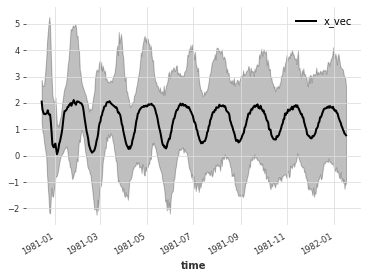

In [64]:
from darts.models import RNNModel  # probabilistic

modlstmGaussian = RNNModel(model="LSTM", input_chunk_length=96, n_rnn_layers=1, dropout=0, hidden_dim=25, training_length=200, likelihood=GaussianLikelihood())
modlstmGaussian.fit(series)
predlstmGaussian = modlstmGaussian.predict(horizon, num_samples=1000)

predlstmGaussian.plot()

In [101]:
from darts.models import NBEATSModel

modnb = NBEATSModel(input_chunk_length=96, output_chunk_length=horizon)
modnb.fit(series)
prednb = modnb.predict(horizon)

prednb.plot()

[2021-12-30 18:18:43,506] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3505 samples.
[2021-12-30 18:18:43,506] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3505 samples.
[2021-12-30 18:18:43,647] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-30 18:18:43,647] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


[2021-12-30 15:56:26,277] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3857 samples.
[2021-12-30 15:56:26,277] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3857 samples.
[2021-12-30 15:56:26,283] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2021-12-30 15:56:26,283] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2021-12-30 15:56:26,288] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-30 15:56:26,288] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


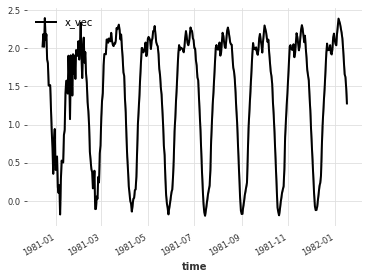

In [66]:
#deterministic
from darts.models import TCNModel

modtcn = TCNModel(input_chunk_length=96, output_chunk_length=48, dropout=0, kernel_size=3, num_filters=3)
modtcn.fit(series)
predtcn= modtcn.predict(horizon, num_samples=1000)

predtcn.plot()

[2021-12-30 15:52:01,988] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3857 samples.
[2021-12-30 15:52:01,988] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3857 samples.
[2021-12-30 15:52:01,995] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2021-12-30 15:52:01,995] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2021-12-30 15:52:02,002] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-30 15:52:02,002] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


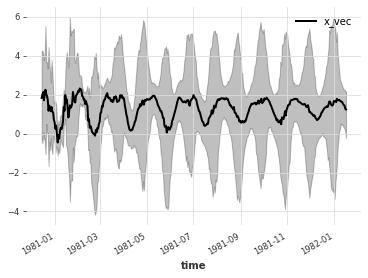

In [65]:
#probabilistic
modtcnGaussian = TCNModel(input_chunk_length=96, output_chunk_length=48, dropout=0, kernel_size=3, num_filters=3, likelihood=GaussianLikelihood())
modtcnGaussian.fit(series)
predtcnGaussian= modtcnGaussian.predict(horizon, num_samples=1000)

predtcnGaussian.plot()

In [67]:
num_freqs = [2, 2]
num_fourier = 2
model = model_objs.NormalNLL(x_dim=x.shape[1], num_freqs=num_freqs, n=256)
k = koopman_probabilistic.KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)
k.find_fourier_omegas(x[:train_through], hard_code=[48, 31])

fourier periods: tensor([48.0000, 31.0000], dtype=torch.float64)


tensor([0.1309, 0.2027], dtype=torch.float64)

In [68]:
k.fit(x[:train_through], iterations=8000, verbose=True, interval=20, cutoff=0, weight_decay=1e-7, lr_theta=1e-4, lr_omega=0, training_mask=None);

Iteration  0
tensor([48.0000, 31.0000, 48.0000, 31.0000])
Setting periods to tensor([48.0000, 31.0000, 48.0000, 31.0000], grad_fn=<MulBackward0>)
Loss:  1.9533906571629676
Iteration  1
tensor([48.0000, 31.0000, 48.0000, 31.0000])
Setting periods to tensor([48.0000, 31.0000, 48.0000, 31.0000], grad_fn=<MulBackward0>)
Loss:  1.9181581379300463
Iteration  2
tensor([48.0000, 31.0000, 48.0000, 31.0000])
Setting periods to tensor([48.0000, 31.0000, 48.0000, 31.0000], grad_fn=<MulBackward0>)
Loss:  1.8825982577294214
Iteration  3
tensor([48.0000, 31.0000, 48.0000, 31.0000])
Setting periods to tensor([48.0000, 31.0000, 48.0000, 31.0000], grad_fn=<MulBackward0>)
Loss:  1.8466660474832226
Iteration  4
tensor([48.0000, 31.0000, 48.0000, 31.0000])
Setting periods to tensor([48.0000, 31.0000, 48.0000, 31.0000], grad_fn=<MulBackward0>)
Loss:  1.810324752812797
Iteration  5
tensor([48.0000, 31.0000, 48.0000, 31.0000])
Setting periods to tensor([48.0000, 31.0000, 48.0000, 31.0000], grad_fn=<MulBackwar

In [69]:
predict_through = train_through + horizon
params = k.predict(predict_through)
mu_hat, sigma_hat = params

In [70]:
path = "./darts_comparisons/synthGaussian1"
np.save(path + "_mu.py", mu_hat)
np.save(path + "_sigma.py", sigma_hat)

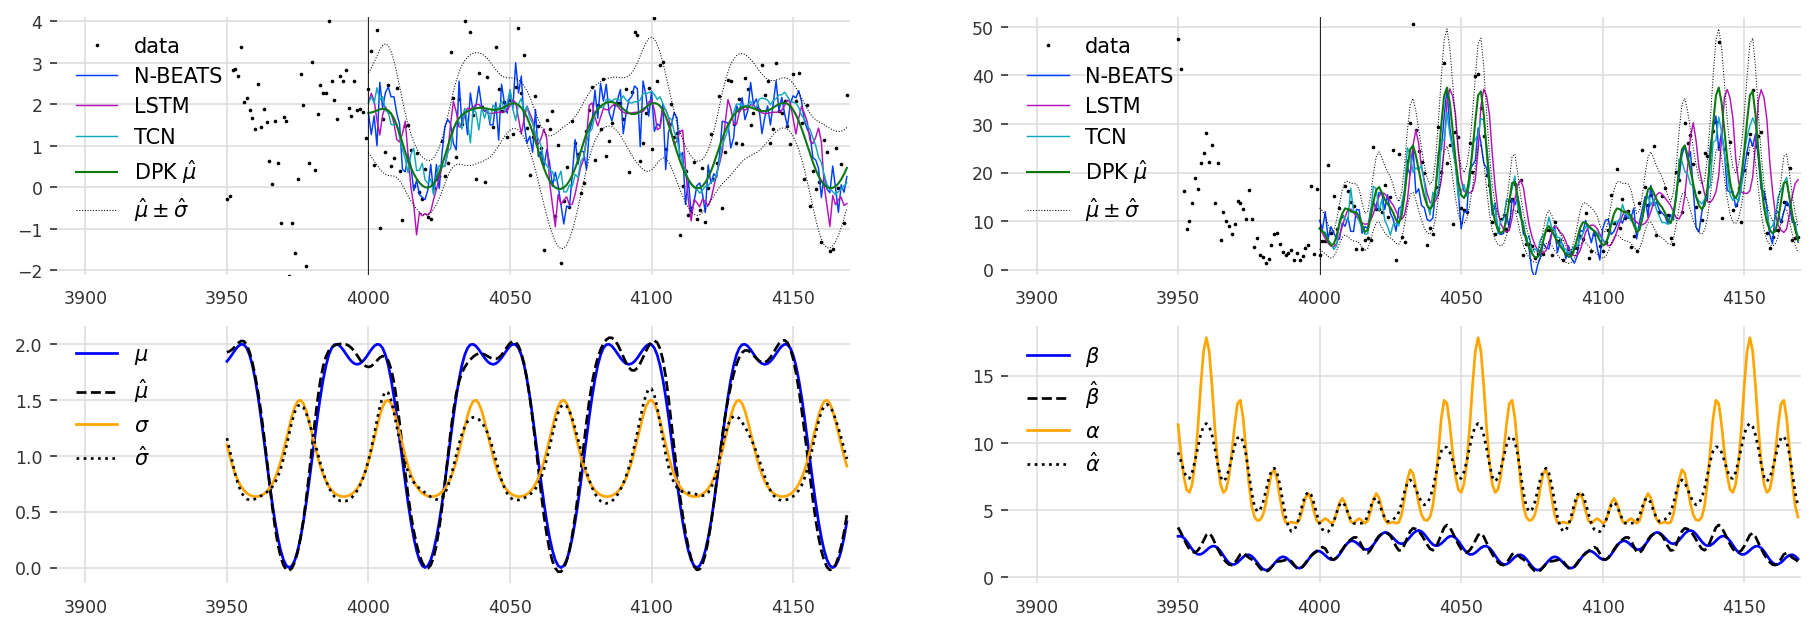

In [107]:
predict_through = train_through + horizon
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 5), dpi=150)
idx = 50
end_offset = 180
start = train_through - idx
end = predict_through - idx - end_offset
pt = np.arange(predict_through)
axs[0, 0].plot(pt[start:end], x[start:end], ".", label="data", markersize=1.5)
axs[0, 0].plot(pt[train_through:end], prednb[:horizon - idx - end_offset].values()[:, 0],  "-", linewidth=0.7, label="N-BEATS")
axs[0, 0].plot(pt[train_through:end], predlstm[:horizon - idx - end_offset].values()[:, 0],  "-", linewidth=0.7, label="LSTM")
axs[0, 0].plot(pt[train_through:end], predtcn[:horizon - idx - end_offset].values()[:, 0],  "-", linewidth=0.7, label="TCN")
axs[0, 0].plot(pt[train_through:end], mu_hat[train_through:end], linewidth=1, label="DPK $\hat \mu$")
axs[0, 0].plot(pt[train_through:end], mu_hat[train_through:end] + sigma_hat[train_through:end], ":k", linewidth=0.5, label="$\hat \mu \pm \hat \sigma$")
axs[0, 0].plot(pt[train_through:end], mu_hat[train_through:end] - sigma_hat[train_through:end], ":k", linewidth=0.5)
axs[0, 0].axvline(train_through, color="k", linewidth=0.4)
axs[0, 0].set_xlim([train_through - idx - 60, predict_through - idx - end_offset])
axs[0, 0].set_ylim([-2.1, 4.1])
axs[0, 0].legend(loc="upper left", bbox_to_anchor=[0, 1], framealpha=1)
axs[1, 0].plot(pt[start:end], mu_vec[start:end], "b", label="$\mu$")
axs[1, 0].plot(pt[start:end], mu_hat[start:end], "--k", label="$\hat \mu$")
axs[1, 0].plot(pt[start:end], sigma_vec[start:end], "orange", label="$\sigma$")
axs[1, 0].plot(pt[start:end], sigma_hat[start:end], ":k", label="$\hat \sigma$")
axs[1, 0].set_xlim([train_through - idx - 60, predict_through - idx - end_offset])
axs[1, 0].legend(loc="upper left", bbox_to_anchor=[0, 1], framealpha=1)

axs[0, 1].plot(pt[start:end], x2[start:end], ".", label="data", markersize=1.5)
axs[0, 1].plot(pt[train_through:end], prednb2[:horizon - idx - end_offset].values()[:, 0],  "-", linewidth=0.7, label="N-BEATS")
axs[0, 1].plot(pt[train_through:end], predlstm2[:horizon - idx - end_offset].values()[:, 0],  "-", linewidth=0.7, label="LSTM")
axs[0, 1].plot(pt[train_through:end], predtcn2[:horizon - idx - end_offset].values()[:, 0],  "-", linewidth=0.7, label="TCN")
axs[0, 1].plot(pt[train_through:end], mean_hat2[train_through:end], linewidth=1, label="DPK $\hat \mu$")
axs[0, 1].plot(pt[train_through:end], mean_hat2[train_through:end] + std_hat2[train_through:end], ":k", linewidth=0.5, label="$\hat \mu \pm \hat \sigma$")
axs[0, 1].plot(pt[train_through:end], mean_hat2[train_through:end] - std_hat2[train_through:end], ":k", linewidth=0.5)
axs[0, 1].axvline(train_through, color="k", linewidth=0.4)
axs[0, 1].set_xlim([train_through - idx - 60, predict_through - idx - end_offset])
axs[0, 1].set_ylim([-1, 52])
axs[0, 1].legend(loc="upper left", bbox_to_anchor=[0, 1], framealpha=1)
axs[1, 1].plot(pt[start:end], scale_vec[start:end], "b", label="$\\beta$")
axs[1, 1].plot(pt[start:end], scale_hat[start:end], "--k", label="$\hat \\beta$")
axs[1, 1].plot(pt[start:end], a_vec[start:end], "orange", label="$\\alpha$")
axs[1, 1].plot(pt[start:end], a_hat[start:end], ":k", label="$\hat \\alpha$")
axs[1, 1].set_xlim([train_through - idx - 60, predict_through - idx - end_offset])
axs[1, 1].legend(loc="upper left", bbox_to_anchor=[0, 1], framealpha=1)
plt.show()


In [104]:
print("DPK:", MAE(x[train_through:train_through + horizon], mu_hat[train_through:]))
print("NBEATS:", MAE(x[train_through:train_through + horizon], prednb.values()))
print("TCN:", MAE(x[train_through:train_through + horizon], predtcn.values()))
print("LSTM:", MAE(x[train_through:train_through + horizon], predlstm.values()))

DPK: 0.7471052946894011
NBEATS: 0.8236279864259015
TCN: 0.8084841459021144
LSTM: 0.8397519513597013


In [ ]:
num_quants = 9
quantiles = np.arange(1, num_quants + 1, dtype=np.float32) / (num_quants + 1)
predlstmquantiles = predlstmGaussian.quantiles_df(quantiles)
predtcnquantiles = predtcnGaussian.quantiles_df(quantiles)

predlstmquantiles = np.array([[float(predlstmquantiles.values[i, j].values) for j in range(num_quants)] for i in range(horizon)])
predtcnquantiles = np.array([[float(predtcnquantiles.values[i, j].values) for j in range(num_quants)] for i in range(horizon)])

path = "./darts_comparisons/synthGaussian1"
mu_hat = np.load(path + "_mu.py.npy")
sigma_hat = np.load(path + "_sigma.py.npy")

quant_preds = gaussian_quantiles(mu_hat, sigma_hat, quantiles=quantiles)

print("DPK:", pinball_loss(x[train_through:train_through + horizon], quant_preds[train_through:], quantiles))
print("LSTM:", pinball_loss(x[train_through:train_through + horizon], predlstmquantiles, quantiles))
print("TCN:", pinball_loss(x[train_through:train_through + horizon], predtcnquantiles, quantiles))

DPK: [0.30530347]
LSTM: [0.34002059]
TCN: [0.31817764]


In [76]:
num_quants = 9
quantiles = np.arange(1, num_quants + 1, dtype=np.float32) / (num_quants + 1)
predlstmquantiles = predlstmGaussian.quantiles_df(quantiles)
predtcnquantiles = predtcnGaussian.quantiles_df(quantiles)

predlstmquantiles = np.array([[float(predlstmquantiles.values[i, j].values) for j in range(num_quants)] for i in range(horizon)])
predtcnquantiles = np.array([[float(predtcnquantiles.values[i, j].values) for j in range(num_quants)] for i in range(horizon)])

path = "./darts_comparisons/synthGaussian1"
mu_hat = np.load(path + "_mu.py.npy")
sigma_hat = np.load(path + "_sigma.py.npy")

quant_preds = gaussian_quantiles(mu_hat, sigma_hat, quantiles=quantiles)

print("DPK:", pinball_loss(x[train_through:train_through + horizon], quant_preds[train_through:], quantiles))
print("LSTM:", pinball_loss(x[train_through:train_through + horizon], predlstmquantiles, quantiles))
print("TCN:", pinball_loss(x[train_through:train_through + horizon], predtcnquantiles, quantiles))

DPK: [0.28842925]
LSTM: [0.30645992]
TCN: [0.32377181]


In [ ]:
pinballs = {"DPK": [], "LSTM": [], "TCN": []}
MAEs = {"DPK": [], "LSTM": [], "TCN": [], "NBEATS": []}

In [142]:
for h in horizons:
    
    print(h)
    print("# dpk")
    predict_through = train_through + h
    _params = k.predict(predict_through)
    _rate_hat, _a_hat = _params
    _scale_hat = 1 / _rate_hat
    path = "./darts_comparisons/synthGaussian1_" + str(h)
    np.save(path + "_rate.py", _rate_hat)
    np.save(path + "_a.py", _a_hat)
    _mean_hat = model.mean(_params)
    _std_hat = model.std(_params)
    _quant_preds = gaussian_quantiles(_rate_hat, _a_hat, quantiles=quantiles)
    pinballs["DPK"].append(pinball_loss(x[train_through:train_through + h], _quant_preds[train_through:], quantiles))
    MAEs["DPK"].append(MAE(x[train_through:train_through + h], _mean_hat[train_through:]))

    print("# lstm gamma")
    _predlstmGaussian = modlstmGaussian.predict(h, num_samples=1000)
    _predlstmquantiles = _predlstmGaussian.quantiles_df(quantiles)
    _predlstmquantiles = np.array([[float(_predlstmquantiles.values[i, j].values) for j in range(num_quants)] for i in range(h)])
    pinballs["LSTM"].append(pinball_loss(x[train_through:train_through + h], _predlstmquantiles, quantiles))

    # lstm
    _predlstm = mod.predict(h)
    MAEs["LSTM"].append(MAE(x[train_through:train_through + h], _predlstm.values()))

    print("# tcn gamma")
    _predtcnGaussian = modtcnGaussian.predict(h, num_samples=1000)
    _predtcnquantiles = _predtcnGaussian.quantiles_df(quantiles)
    _predtcnquantiles = np.array([[float(_predtcnquantiles.values[i, j].values) for j in range(num_quants)] for i in range(h)])
    pinballs["TCN"].append(pinball_loss(x[train_through:train_through + h], _predtcnquantiles, quantiles))

    # tcn
    _predtcn = modtcn.predict(h)
    MAEs["TCN"].append(MAE(x[train_through:train_through + h], _predtcn.values()))

    # nbeats WARNING this is not how N-BEATs is meant to be used since it must be trained for a specific forecast horizon--only read h=horizon
    _prednb = modnb.predict(h)
    MAEs["NBEATS"].append(MAE(x[train_through:train_through + h], _prednb.values()))
    

10
50
100
400
1000
10000
100000


In [90]:
pinballs

{'DPK': [array([0.45276019]),
  array([0.3458772]),
  array([0.32560003]),
  array([0.28842925]),
  array([0.29287259]),
  array([0.29827341]),
  array([0.30018602])],
 'LSTM': [array([0.47660864]),
  array([0.36380124]),
  array([0.33811019]),
  array([0.30737424]),
  array([0.33217332]),
  array([0.37979419])],
 'TCN': [array([0.47909291]),
  array([0.38370767]),
  array([0.35284627]),
  array([0.32418736]),
  array([0.35262262]),
  array([0.38498422])]}

In [143]:
MAEs

{'DPK': [1.2251702935159663,
  0.9049409980252523,
  0.8447879019514432,
  0.7471052946894011,
  0.76353912805659,
  0.771513551051561,
  0.7757316212256883],
 'LSTM': [1.1301181985181716,
  0.9050080013629638,
  0.8556327804838656,
  0.8397519513597013,
  0.9866590794140202,
  1.2122830447125619],
 'TCN': [1.1410217271826149,
  0.9489321757958359,
  0.8785283422780862,
  0.8084841459021144,
  0.9301212999481179,
  1.2474032485964883],
 'NBEATS': [1.4968890223307612,
  0.976095357367296,
  0.8754019004124287,
  0.8236279864259015,
  0.9216380674383661,
  0.8286323034169307,
  0.8334408481530103]}

In [147]:
plt.legend?

Signature: plt.legend(*args, **kwargs)
Docstring:
Place a legend on the Axes.

Call signatures::

    legend()
    legend(handles, labels)
    legend(handles=handles)
    legend(labels)

The call signatures correspond to the following different ways to use
this method:

**1. Automatic detection of elements to be shown in the legend**

The elements to be added to the legend are automatically determined,
when you do not pass in any extra arguments.

In this case, the labels are taken from the artist. You can specify
them either at artist creation or by calling the
:meth:`~.Artist.set_label` method on the artist::

    ax.plot([1, 2, 3], label='Inline label')
    ax.legend()

or::

    line, = ax.plot([1, 2, 3])
    line.set_label('Label via method')
    ax.legend()

Specific lines can be excluded from the automatic legend element
selection by defining a label starting with an underscore.
This is default for all artists, so calling `.Axes.legend` without
any arguments and without setting 

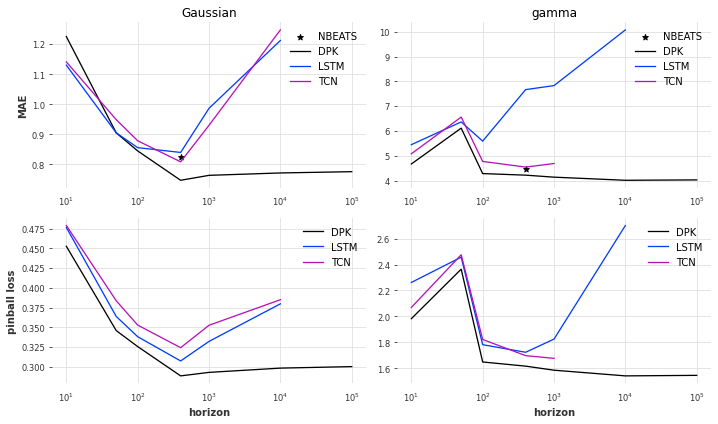

In [158]:
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.title("Gaussian")
plt.scatter([horizon], [MAEs["NBEATS"][horizons.index(horizon)]], marker="*", label="NBEATS")
for p in pinballs:
    plt.plot(horizons[:len(MAEs[p])], MAEs[p], label=p)
plt.ylabel("MAE")
plt.semilogx()
plt.legend()

plt.subplot(222)
plt.title("gamma")
plt.scatter([horizon], [MAEs2["NBEATS"][horizons.index(horizon)]], marker="*", label="NBEATS")
for p in pinballs:
    plt.plot(horizons[:len(MAEs2[p])], MAEs2[p], label=p)
plt.semilogx()
plt.legend()

plt.subplot(223)
for p in pinballs:
    plt.plot(horizons[:len(pinballs[p])], pinballs[p], label=p)
plt.ylabel("pinball loss")
plt.xlabel("horizon")
plt.semilogx()
plt.legend()

plt.subplot(224)
for p in pinballs2:
    plt.plot(horizons[:len(pinballs2[p])], pinballs2[p], label=p)
plt.xlabel("horizon")
plt.semilogx()
plt.legend()

plt.tight_layout()
plt.show()

# 3D plot

In [210]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


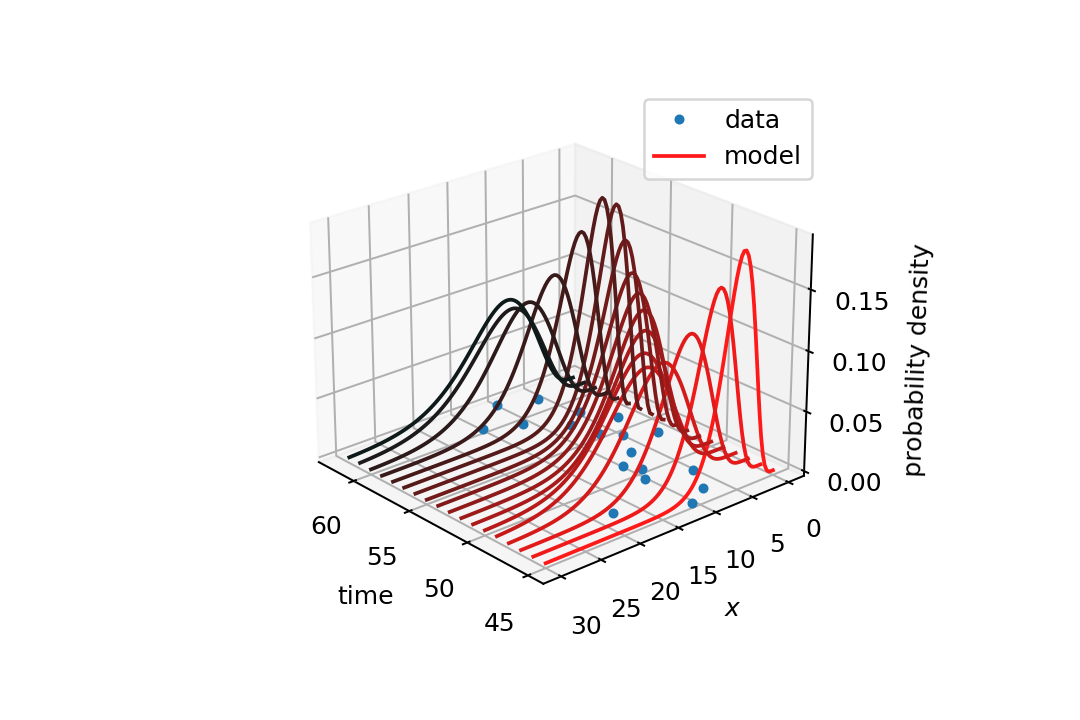

In [233]:
# (t, x, pdf)
start = 0
end = 18
step = 1
ts = np.arange(start, end, step)
xs = x[ts]
pdfs = []
fig = plt.figure(dpi=150)
ax = fig.gca(projection='3d')
ax.plot(ts, xs, np.zeros(len(xs)), ".")
for t in ts:
    lins = np.linspace(0, 30, 100)
    pdf = gamma.pdf(lins, a_hat[t], scale=scale_hat[t])
    pdfs.append(pdf)
    ax.plot(t * np.ones(len(lins)), lins, pdf, color=(((end - t) / (end - start)), 0.1, 0.1))
plt.xlabel("time")
plt.ylabel("$x$")
ax.set_zlabel("probability density")
plt.legend(["data", "model"])